# Recomendador publicitario basado en **Reinforcement Learning**

**By:** Pedro Ruiz  

---

En este notebook implementaremos un sistema de recomendación publicitario utilizando Reinforcement Learning, concretamente el algortimo Q-learning.

Para ello nos basaremos en las categorias (`05_vectorization.ipynb.`) y las recomendaciones de videos (`07_video_recommender.ipynb`) 

Posteriormente simularemos un entorno donde, al reproducir un vídeo, se muestra un anuncio (corto o largo) de alguna categoría. El objetivo del agente es maximizar la recompensa esperada asociada a las visualizaciones de anuncios.


El Notebook consta de:

1. **Importaciones**
2. **Configuración y carga de datos**
3. **Recomendación de vídeos similares** 
4. **Definición del entorno simulado** 
5. **Entrenamiento con Q-learning** 
6. **Visualización**
7.  **Política aprendida**


## 1. Importaciones

In [1]:
import os
import configparser
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import random
import matplotlib.pyplot as plt
import optuna
from optuna.pruners import MedianPruner

## 2. Configuración y carga de datos

In [2]:
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

config = configparser.ConfigParser()
config_path = os.path.join(project_root, 'config', 'settings.conf')
config.read(config_path)

vectorized_data_path = os.path.join(project_root, config['data']['output_vector_path'])

df = pd.read_csv(vectorized_data_path)

categories = df['category'].unique()
print("Categorías detectadas:", categories)

X = df.drop(columns=['category', 'video_name']).values
video_names = df['video_name'].values
video_categories = df['category'].values

Categorías detectadas: ['cooking' 'traffic' 'videoclip']


## 3. Recomendación de vídeos similares

A continuacion aplicaremos la función `recommend_similar` que es una variante que desarrollamos en `07_video_recommender.ipynb`, que recibe el nombre de un vídeo y devuelve una lista de los más similares (en términos de sus vectores de características) usando la distancia del coseno.

Estos vídeos similares nos servirán para simular el cambio de "estado" dentro del entorno. El estado está representado por la categoría del siguiente vídeo que se mostrará.

In [3]:
def recommend_similar(video_name, top_k=10):
    idx = np.where(video_names == video_name)[0]
    if len(idx) == 0:
        return []
    idx = idx[0]
    query = X[idx].reshape(1, -1)
    dists = cosine_distances(query, X)[0]
    nearest = np.argsort(dists)
    nearest = nearest[nearest != idx]
    top_indices = nearest[:top_k]
    results = df.iloc[top_indices][['category', 'video_name']]
    return results

## 4. Definición del entorno

En este punto porcederemos a generar un entorno simulado donde el agente seleccione entre anuncios cortos y largos para cada categoría, obteniendo recompensas basadas en la probabilidad de que el usuario vea el anuncio.

En este entorno, el estado está definido por la categoría actual del vídeo. La acción consiste en seleccionar qué anuncio mostrar, combinando dos factores:

- Categoría de anuncio: `cooking`, `traffic` o `videoclip`.
- Tipo de anuncio: `short` o `long`.

Cada tipo de anuncio tiene una probabilidad de ser visto por el usuario y una recompensa asociada. La función `env_step` simula el resultado de mostrar un anuncio, determinando la recompensa y el siguiente estado.

In [4]:
category_to_idx = {c: i for i, c in enumerate(categories)}                          # Mapeamos cada categoría a un índice

# Parámetros
ad_info = {                                                                         # Información de los anuncios (probabilidad y recompensa por tipo de anuncio)                                
    'cooking': {
        'long': (0.3, 3),                                                           # anuncios largos en 'cooking'
        'short': (0.7, 1)                                                           # anuncios cortos en 'cooking'
    },
    'traffic': {
        'long': (0.4, 2),
        'short': (0.8, 1)
    },
    'videoclip': {
        'long': (0.5, 2),
        'short': (0.9, 1)
    }
}

# Simulador de paso en el entorno
def env_step(current_category, action, top_k=5):                                    # Recibe la categoría actual, la acción y el número de recomendaciones a devolver,
    cat_idx = action // 2                                                           # e inicamos el índice de la categoría,
    tipo_idx = action % 2                                                           # el indice del tipo de anuncio,
    ad_cat = categories[cat_idx]                                                    # la categoría del anuncio,
    ad_type = 'short' if tipo_idx == 0 else 'long'                                  # y el tipo de anuncio (0 para corto, 1 para largo),

    p, r = ad_info[ad_cat][ad_type]                                                 # Pasamos a obtener la probabilidad y la recompensa del anuncio,
    user_view = np.random.rand()                                                    # barajamos un número aleatorio para simular la visualización del usuario,
    reward = r if user_view < p else 0.0                                            # si el usuario ve el anuncio, se le otorga la recompensa. Si no, se valora con un 0.

    # Seleccion de un vídeo actual al azar
    vids_cat = df[df['category'] == current_category]['video_name'].values          # Extraemos los videos de la categoría actual,
    current_video = np.random.choice(vids_cat)                                      # seleccionamos un video random de la categoria que trabajamos
    sim_vids = recommend_similar(current_video, top_k=top_k)                        # y recomendamos videos similares al video actual.
    if len(sim_vids) == 0:                                                          # si no existen videos similares
        next_category = current_category                                            # nos quedamos en la misma categoría
    else:
        chosen = sim_vids.sample(1).iloc[0]                                         # si existen videos similares, seleccionamos uno al azar
        next_category = chosen['category']                                          # y nos movemos dentro de la categoría del video seleccionado.

    return next_category, reward

## 5. Entrenamiento con Q-learning

Ahora pasaremos a entrenar el agente de recomendación. 
El agente aprenderá una matriz Q, donde cada fila representa un estado (una categoría de vídeo) y cada columna una acción (categoría de anuncio + tipo).

- `alpha`: gestiona la tasa de aprendizaje.
- `gamma`: el factor de descuento.
- `epsilon`: la probabilidad de explorar (escoger acciones aleatorias).

El bucle de entrenamiento consistira en ejecutar varios episodios. En cada episodio, el agente realizara:

1. La seleccion de un estado inicial.
2. y a continuacion:
   - Selecciona una acción (explorando o explotando la matriz Q).
   - Observa la recompensa y el siguiente estado.
   - Actualiza la matriz Q.

In [5]:
num_states = len(categories)                                                        # Extraemos el número de estados posibles (las categorías)
num_actions = num_states * 2                                                        # y el número de acciones posibles (2 tipos de anuncios por categoría)

Q = np.zeros((num_states, num_actions))                                             # Inicializa la matriz Q con ceros

# Hiperparámetros
alpha = 0.1                                                                         # implementamos la tasa de aprendizaje,
gamma = 0.9                                                                         # el factor de descuento,
epsilon = 0.1                                                                       # la probabilidad de exploración,
num_episodes = 1000                                                                 # y el número de episodios.

rewards_per_episode = []                                                            # inicializamos una lista para almacenar las recompensas por episodio

# Bucle de episodios
for episode in range(num_episodes):
    state_idx = np.random.randint(num_states)                                       # En cada episodio, seleccionamos un estado aleatorio,
    state_category = categories[state_idx]                                          # obtenemos la categoria correspondiente al estado,
    total_reward = 0                                                                # e inicializamos la recompensa total a 0.

    for _ in range(10):                                                             # Limitamos el número de pasos por episodio a 10
        if np.random.rand() < epsilon:                                              # y decidimos si explorar o explotar (con probabilidad epsilon)
            action = np.random.randint(num_actions)                                 # Exploración: selecciona una acción aleatoria
        else:
            action = np.argmax(Q[state_idx])                                        # Explotación: selecciona la mejor acción según la matriz Q

        next_category, reward = env_step(state_category, action)                    # Ejecutamos la accion la acción y obtenemos la próxima categoría y recompensa
        next_state_idx = category_to_idx[next_category]                             # y obtenemos el índice del próximo estado basado en la categoría

        # Actualiza valor Q para el estado y acción actuales usando la fórmula de Q-learning
        Q[state_idx, action] += alpha * (reward + gamma * np.max(Q[next_state_idx]) - Q[state_idx, action])
        total_reward += reward                                                      # Acumulamos la recompensa obtenida en este paso

        state_idx = next_state_idx                                                  # y actualizamos el estado actual al siguiente estado

    rewards_per_episode.append(total_reward)                                        # Se almacena la recompensa total del episodio


## 6. Visualización

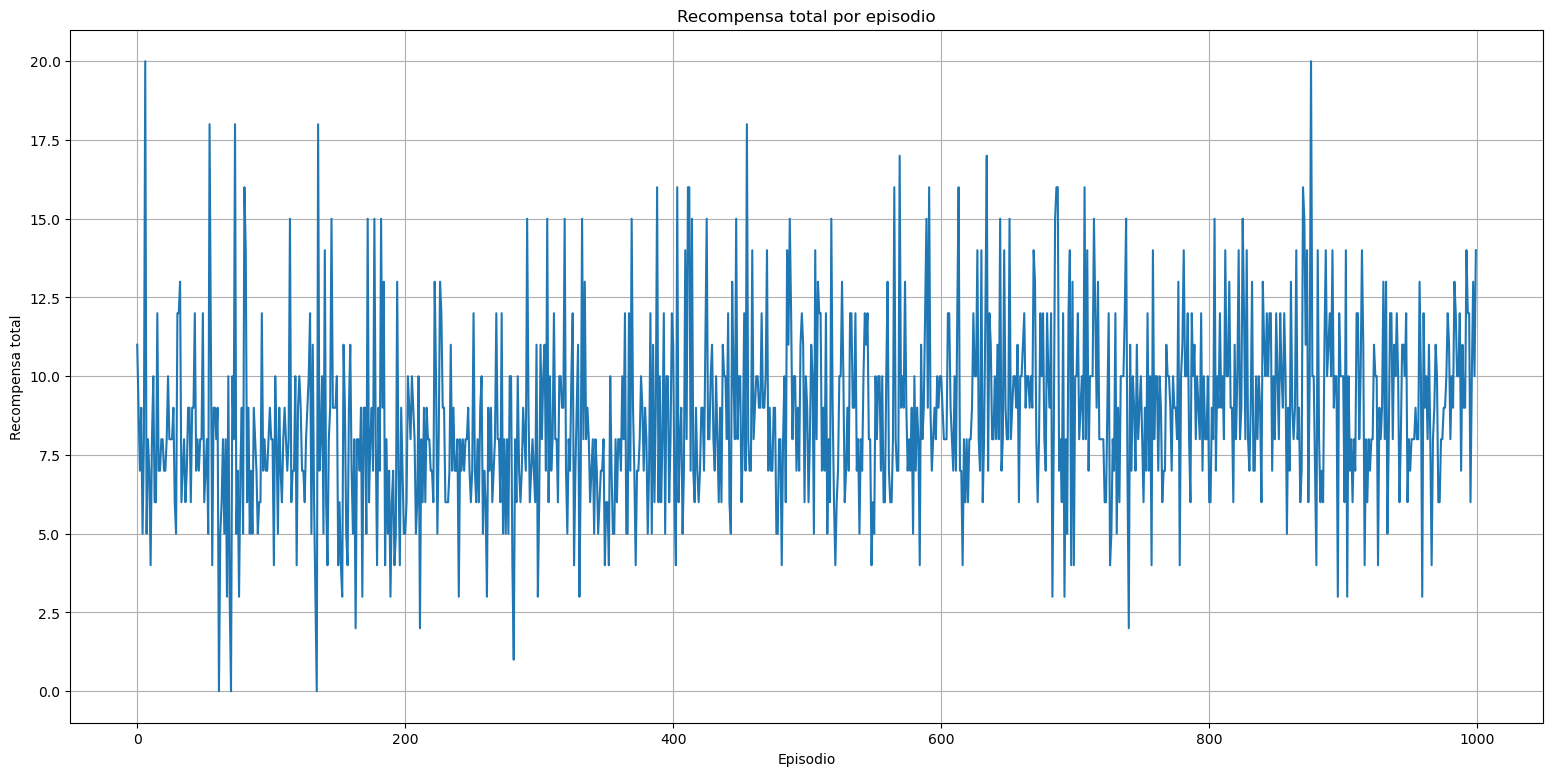

In [6]:
plt.figure(figsize=(19, 9))

plt.plot(rewards_per_episode)
plt.title("Recompensa total por episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")

plt.grid()
plt.show()

La gráfica nos muestra la recompensa total por episodio a lo largo del entrenamiento. Aunque no existe una tendencia claramente alcista, sí existe una cierta estabilización en un rango medio (aproximadamente entre 5 y 12 puntos de recompensa por episodio). 

Lo que nos esta sugiriendo que el agente ha aprendido una política que, aunque no es óptima para lograr recompensas elevadas, sí que mantiene un nivel de desempeño consistente.

## 7. Política aprendida

In [7]:
for i, cat in enumerate(categories):
    best_action = np.argmax(Q[i])
    cat_ad = best_action // 2
    ad_type = best_action % 2
    chosen_cat = categories[cat_ad]
    chosen_type = 'short' if ad_type == 0 else 'long'
    print(f"Para categoría {cat}, mejor anuncio: {chosen_type} de {chosen_cat}")

Para categoría cooking, mejor anuncio: long de videoclip
Para categoría traffic, mejor anuncio: long de videoclip
Para categoría videoclip, mejor anuncio: long de videoclip


Según los resultados, el agente ha aprendido que los anuncios largos de "videoclip" son la mejor opción en todas las categorías de vídeo: `cooking`, `traffic` y `videoclip`. Esto sugiere que la recompensa esperada de esta combinación domina gracias a su equilibrio entre alta recompensa y probabilidad suficiente de visualización.

El agente prioriza maximizar la recompensa en lugar de mantener una coherencia temática entre el vídeo y el anuncio.